In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
data = pd.read_csv("raw_data1_with_labels.csv", index_col = 0)
print(data.shape)
data.head()

(898, 5)


,title,y,upload_date,view_count,query
0,Assessing Federated Machine Learning's Potenti...,0,2020-10-26,1,machine+learning
1,Alexa: Which is the Best Instance to Run Machi...,1,2020-10-26,28,machine+learning
2,Tesla vs comma.ai approach to machine learning...,0,2020-10-26,1,machine+learning
3,Explore Machine Learning Models with Explainab...,1,2020-10-26,8,machine+learning
4,8. Deep Learning Tutorial (Bengali) | Padding ...,0,2020-10-26,16,machine+learning


In [42]:
# As it can be seen, the data has 5 columns, where the y is our label and the other can be the features used to train our model
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 897
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        898 non-null    object
 1   y            898 non-null    int64 
 2   upload_date  898 non-null    object
 3   view_count   898 non-null    int64 
 4   query        898 non-null    object
dtypes: int64(2), object(3)
memory usage: 42.1+ KB


In [43]:
df = data.copy()

y = df['y'] # we take our labels
y.shape

(898,)

In [44]:
features = pd.DataFrame(index = df.index)
text = pd.DataFrame(index = df.index)

text['title'] = df['title']
features['date'] = pd.to_datetime(df['upload_date'])
features['view_count'] = df['view_count']

print(text.shape)
text.head()
                                  

(898, 1)


,title
0,Assessing Federated Machine Learning's Potenti...
1,Alexa: Which is the Best Instance to Run Machi...
2,Tesla vs comma.ai approach to machine learning...
3,Explore Machine Learning Models with Explainab...
4,8. Deep Learning Tutorial (Bengali) | Padding ...


In [45]:
features['time_since_pub'] = (pd.to_datetime("2020-12-12") - features['date']) / np.timedelta64(1, 'D') 
features['views_per_day'] = features['view_count'] /  features['time_since_pub']
features.drop(columns = ["time_since_pub"], inplace = True)
print(features.shape)
features.head()

(898, 3)


,date,view_count,views_per_day
0,2020-10-26,1,0.021277
1,2020-10-26,28,0.595745
2,2020-10-26,1,0.021277
3,2020-10-26,8,0.170213
4,2020-10-26,16,0.340426


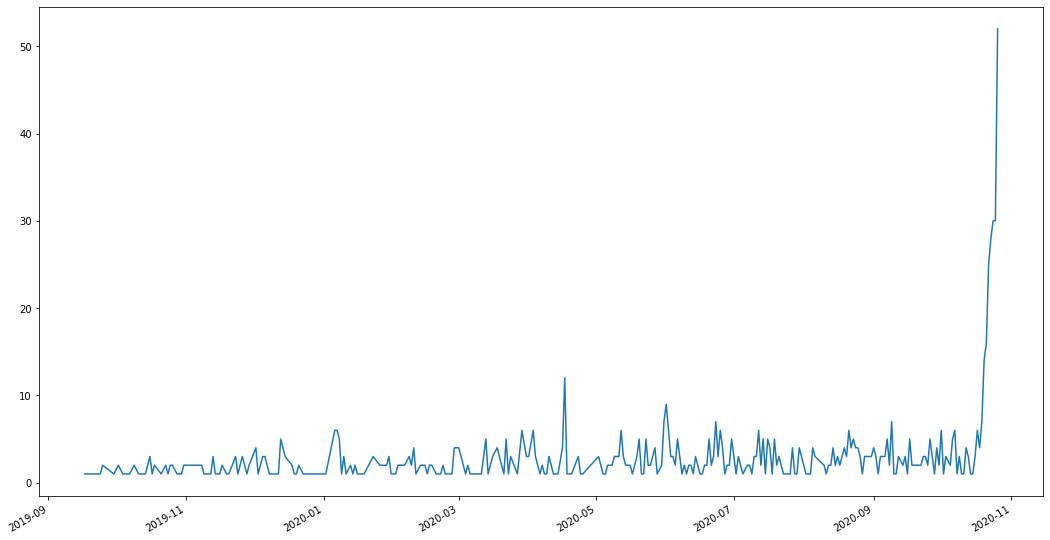

In [46]:
features['date'].value_counts().plot(figsize = (18, 10))

In [55]:
mask1 = features['date'] <= "2020-08-31" # 63% - be use to train the model
mask2 = features['date'] > "2020-08-31" # 27% - be use to test the model

In [57]:
mask1.value_counts()

True     573
False    325
Name: date, dtype: int64

In [58]:
features.drop(columns = ["date"], inplace = True) # We not be using the date as a feature

In [59]:
X_train, X_val = features[mask1], features[mask2]
y_train, y_val = y[mask1], y[mask2]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((573, 2), (573,), (325, 2), (325,))

## Building the Baseline

In [62]:
# Now we can build a baseline with this values, a baseline is a start point where with this metrics we can optmizer our model

from sklearn.tree import DecisionTreeClassifier

In [63]:
mdl = DecisionTreeClassifier(random_state = 0, max_depth=2, class_weight = "balanced") # because in the dataset we have most "0"
                                                              # then "1's", we need to balance the weights to reduce overfitting
    
mdl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [64]:
p = mdl.predict_proba(X_val)[:, 1]

In [65]:
from sklearn.metrics import roc_auc_score, average_precision_score

average_precision_score(y_val, p), roc_auc_score(y_val, p)

(0.24974358974358976, 0.5064102564102564)

*So this are the baseline for the metrics **Average Precision** : 0.24974358974358976 and the **Roc Auc score** : 0.5064102564102564. Now, we can optmizer our model using another models and tunning the hyperparameters*

[Text(279.0, 453.0, 'views_per_day <= 0.003\ngini = 0.5\nsamples = 573\nvalue = [286.5, 286.5]'),
 Text(139.5, 271.8, 'views_per_day <= 0.002\ngini = 0.332\nsamples = 29\nvalue = [17.267, 4.584]'),
 Text(69.75, 90.59999999999997, 'gini = 0.46\nsamples = 3\nvalue = [1.279, 2.292]'),
 Text(209.25, 90.59999999999997, 'gini = 0.219\nsamples = 26\nvalue = [15.988, 2.292]'),
 Text(418.5, 271.8, 'views_per_day <= 0.005\ngini = 0.5\nsamples = 544\nvalue = [269.233, 281.916]'),
 Text(348.75, 90.59999999999997, 'gini = 0.341\nsamples = 18\nvalue = [5.756, 20.628]'),
 Text(488.25, 90.59999999999997, 'gini = 0.5\nsamples = 526\nvalue = [263.478, 261.288]')]

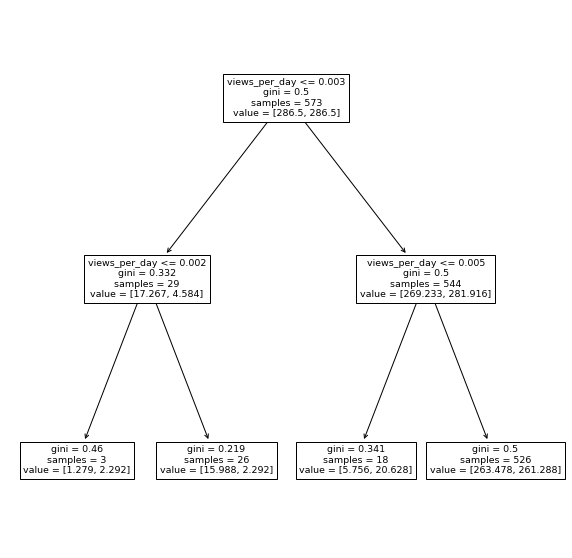

In [67]:
import pylab
from sklearn.tree import plot_tree

fig, ax = pylab.subplots(1, 1, figsize = (10, 10))
plot_tree(mdl, ax = ax, feature_names=X_train.columns)


## Using the text  as feature

*Now we can use the text (title column) as feature to improve our model metrics, for that we'll be using the bag of words representation with the  the **TF-IDF** measure.*

*A  **Bag of Words** is a way of extracting features from texts. It's representantion of text that describes the occurence of words within a document.*

*The **TF-IDF** (Term Frequency Inverse Document Frequency)  is a bag of words measure where the words with high frequencies are penalized.*

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

title_train = np.squeeze(text[mask1])
title_val = np.squeeze(text[mask2])
print(title_train.shape, title_val.shape)

title_vec = TfidfVectorizer(min_df = 2, ngram_range=(1, 2)) # min_df is the minimum appearence of words in the corpus, 
                                                            # the ngram_range is the ngram words in the corpus (in this case 
                                                            # the unigram and bigram)
        
title_train_bow = title_vec.fit_transform(title_train)
title_val_bow = title_vec.transform(title_val)
print(title_train_bow.shape, title_val_bow.shape)

(573,) (325,)
(573, 1121) (325, 1121)


In [86]:
title_train_bow

<573x1121 sparse matrix of type '<class 'numpy.float64'>'
	with 6640 stored elements in Compressed Sparse Row format>

In [87]:
from scipy.sparse import hstack

X_train_with_title = hstack([X_train, title_train_bow])
X_val_with_title = hstack([X_val, title_val_bow])

X_train_with_title.shape, X_val_with_title.shape

((573, 1123), (325, 1123))

*Now we create a ensemble model to see the difference:*

In [88]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state = 0, class_weight="balanced")
mdl.fit(X_train_with_title, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=0)

In [89]:
p = mdl.predict_proba(X_val_with_title)[:, 1]

In [90]:
average_precision_score(y_val, p), roc_auc_score(y_val, p)

(0.4398304045590999, 0.6974981833281428)

*Just adding the text as a feature we had a great improvement:*

*We get an **average_precision_score** : 0.4398304045590999 and  **roc_auc_score** : 0.6974981833281428*